In [ ]:
from huggingface_hub import login
login(token="")

In [2]:
import torch

if torch.cuda.is_available():
    print(f"CUDA is available! GPU: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available.")

CUDA is available! GPU: NVIDIA GeForce RTX 2080 Ti


In [3]:
#!/usr/bin/env python
# coding: utf-8

import networkx as nx
import random
from typing import List, Union
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import time
import csv
import os
import torch
import numpy as np
import re
import logging
import transformers
from transformers import AutoTokenizer, pipeline
import pandas as pd
from typing import Dict, Optional, Tuple
import json 
from itertools import product

2025-10-16 04:37:48.340766: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-16 04:37:48.353469: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760589468.369991  425762 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760589468.374973  425762 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1760589468.387523  425762 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [4]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [5]:
model = "deepseek-ai/deepseek-llm-7b-chat"
# utilize DeepSeek Model
class DeepSeekModel():
    def __init__(self):
        self.model_name = model
        self.tokenizer = None
        self.pipeline = None
        self.__load_model__()
        
        
    def __load_model__(self):
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name, use_auth_token = True)
        
        self.pipeline = transformers.pipeline(
            "text-generation",
            model=self.model_name,
            torch_dtype=torch.float16,
            tokenizer = self.tokenizer,
            device_map="auto",
            #load_in_8bit = True
            )
        if self.tokenizer.pad_token_id is None:
            self.tokenizer.pad_token_id = self.tokenizer.eos_token_id
    
    def generate_response(self, query):
        try:
            # Proper DeepSeek chat prompt format
            formatted_prompt = (
                "<|im_start|>system\n"
                "You are a helpful assistant.<|im_end|>\n"
                "<|im_start|>user\n"
                f"{query}<|im_end|>\n"
                "<|im_start|>assistant\n"
            )
    
            sequences = self.pipeline(
                formatted_prompt,
                do_sample=True,
                top_k=50,
                top_p=0.9,
                temperature=0.7,
                num_return_sequences=1,
                max_new_tokens=128,
                eos_token_id=self.tokenizer.eos_token_id,
                pad_token_id=self.tokenizer.pad_token_id,
                truncation=True
            )
    
            generated_text = sequences[0]['generated_text']
    
            # Extract just the assistant's reply
            if "<|im_start|>assistant" in generated_text:
                assistant_split = generated_text.split("<|im_start|>assistant\n", 1)[-1]
                return assistant_split.strip()
            else:
                return generated_text.strip()
    
        except Exception as e:
            print(f"Generation error: {e}")
            return "Error"


In [6]:
def load_leaders_from_json(json_path: str) -> Dict[str, Dict[str, dict]]:
    """Load leader data from JSON, filtering out non-leader entries like extraction_summary."""
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    if len(data) == 1 and isinstance(next(iter(data.values())), dict):
        data = next(iter(data.values()))

    # Filter out non-leader entries
    leaders_only = {k: v for k, v in data.items() if not k.startswith("extraction_summary")}
    return leaders_only


def get_all_quotes_for_leader(leader_info: dict) -> list:
    """
    Return all quotes for a leader.
    Returns an empty list if no quotes are available.
    """
    return leader_info.get("quotes", [])

def sanitize_hashtag(tag: str) -> str:
    """Ensure hashtag is simple and safe: keep letters, numbers, underscore and leading #."""
    tag = tag.strip()
    if not tag:
        return "#"
    if not tag.startswith("#"):
        tag = "#" + tag
    # Keep only allowed characters (#, a-zA-Z0-9, _)
    cleaned = "#" + re.sub(r"[^A-Za-z0-9_]", "", tag[1:])
    if len(cleaned) == 1:
        return "#Error"
    return cleaned

class Leader:
    def __init__(self, country, name, info):
        self.country = country
        self.name = name
        self.info = info  # store the dictionary with quotes, position, years, etc.
        self.display_name = info.get("name", name)
        self.position = info.get("position", "")
        self.years = info.get("years", "")

In [9]:
def generate_fukushima_event():
    return """In 2023, tensions rose between South Korea and Japan over fishing rights near the Liancourt Rocks, known as Dokdo in Korea and Takeshima in Japan. Both nations claim sovereignty over the small islets and the surrounding waters, which are rich in fish but increasingly overexploited. After South Korean patrol vessels ordered several Japanese trawlers to leave the area, Japan accused Korea of violating maritime law. The incident sparked nationalist reactions on social media and renewed debate over sovereignty, environmental protection, and regional cooperation in the Sea of Japan."""

class TimeStep:
    def __init__(self, observation, reward=None, terminal=False):
        self.observation = observation
        self.reward = reward
        self.terminal = terminal

def compute_country_agreement_heatmap(all_rounds):
    print("all_rounds ", all_rounds)
    """
    Computes and plots a country agreement heatmap.
    all_rounds: list of rounds
        Each round is a list of dicts: {"country": str, "player": str, "hashtag": str}
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from collections import defaultdict

    countries = sorted({entry["country"] for round_list in all_rounds for entry in round_list})
    country_to_idx = {c: i for i, c in enumerate(countries)}
    n = len(countries)

    counts = np.zeros((n, n))
    total = np.zeros((n, n))

    for round_list in all_rounds:
        # Build country -> set of normalized hashtags in this round
        country_hashtags = defaultdict(set)
        for entry in round_list:
            tag = entry["hashtag"].strip().lower()  # normalize
            country_hashtags[entry["country"]].add(tag)
        
        for c1 in countries:
            for c2 in countries:
                h1 = country_hashtags[c1]
                h2 = country_hashtags[c2]
                if h1 and h2:
                    intersection = h1 & h2
                    counts[country_to_idx[c1], country_to_idx[c2]] += len(intersection)
                    total[country_to_idx[c1], country_to_idx[c2]] += max(len(h1), len(h2))

    # Avoid division by zero
    agreement = np.divide(counts, total, out=np.zeros_like(counts), where=total!=0)

    # Plot
    plt.figure(figsize=(8, 6))
    plt.imshow(agreement, cmap="coolwarm", vmin=0, vmax=1)
    plt.colorbar(label="Agreement")
    plt.xticks(range(n), countries, rotation=90)
    plt.yticks(range(n), countries)
    plt.title("Country Agreement Heatmap")
    plt.tight_layout()
    plt.show()

    return agreement



def generate_hashtag_for_leader(leader: Leader,
                                event: str,
                                deepseek: DeepSeekModel,
                                previous_guesses: Optional[List[Tuple[int, str, str]]] = None,
                                current_round: int = 1,
                                max_retries: int = 3) -> str:
    """
    Generate a hashtag using deepseek, injecting a sampled leader quote to add personality.
    previous_guesses: list of tuples (round_num, player_hashtag, neighbor_hashtag)
    """
    # Build previous table string if provided
    previous_table = "Round, Your Guess, Neighbor's Guess\n"
    if previous_guesses and current_round > 1:
        previous_rows = [f"{rnum}, {pgh}, {ngh}" for (rnum, pgh, ngh) in previous_guesses]
        previous_table += "\n".join(previous_rows)

    # Include a leader quote (if available) to provide personality/context
    quotes = get_all_quotes_for_leader(leader.info)
    quote_text = ""
    for q in quotes:
        quote_text += f'Quote for personality: "{q.get("quote")}" (source: {q.get("source")})\nContext: {q.get("context")}\n\n'


    if current_round > 1:
        prompt = (
            f"In the experiment, you earn 1 point if your hashtag matches your assigned neighbor, 0 otherwise.\n\n"
            f"You are acting AS the political leader: {leader.display_name} ({leader.position}, {leader.years}), country: {leader.country}.\n"
            f"{quote_text}"
            f"Round {current_round} information (previous guesses shown):\n{previous_table}\n\n"
            f"Event (original description):\n{event}\n\n"
            f"Considering your leader's rhetorical style above, please produce a short hashtag (1 token starting '#', max 5 words) that you think maximizes the chance your neighbor will choose the same hashtag.\n"
            f"Keep the hashtag concise and possibly reflective of your leader's emphasis. Return only a hashtag (e.g., #CleanEnergy)."
        )
    else:
        prompt = (
            f"You are acting AS the political leader: {leader.display_name} ({leader.position}, {leader.years}), country: {leader.country}.\n"
            f"{quote_text}"
            f"Event (original description):\n{event}\n\n"
            f"Please propose a short hashtag (starts with '#', max 5 words) for this event. Return only the hashtag."
        )

    retries = 0
    while retries < max_retries:
        try:
            response = deepseek.generate_response(prompt)
            # Extract first token starting with #
            hashtags = [word.strip(",.:*)([]\"'") for word in response.split() if word.startswith("#") and len(word) > 1 and word != "##"]
            if hashtags:
                chosen = sanitize_hashtag(hashtags[0])
                return chosen
            # If no explicit hashtag, try to extract something alphanumeric and prefix with #
            # simple fallback: pick last word
            words = [w.strip(",.:;()[]\"'") for w in response.split() if w.strip(",.:;()[]\"'")]
            if words:
                candidate = "#" + re.sub(r"[^A-Za-z0-9_]", "", words[-1])
                if len(candidate) > 1:
                    return sanitize_hashtag(candidate)
            retries += 1
        except Exception as e:
            logger.error(f"Error generating hashtag for {leader.display_name}: {e}")
            retries += 1

    return "#Error"


class FukushimaHashtagGame:
    def __init__(self,
                 leaders_json_path: str,
                 top_group_key: Optional[str] = None,
                 total_rounds: int = 40,
                 k_ws: int = 4,
                 p_ws: float = 0.6,
                 seed: Optional[int] = 42):
        """
        leaders_json_path: path to JSON with countries -> leader_id -> info
        top_group_key: if the JSON top-level contains groups like 'asian_pacific_leaders_quotes'
        """
        random.seed(seed)
        np.random.seed(seed)

        # Load leaders
        raw = load_leaders_from_json(leaders_json_path)
        # raw: country -> leader_id -> info
        self.leaders_dict: Dict[str, Dict[str, Leader]] = {}
        for country, leaders in raw.items():
            self.leaders_dict[country] = {lid: Leader(country, lid, info) for lid, info in leaders.items()}

        # Flatten leader list to game players
        self.players: List[str] = []
        self.player_to_leader: Dict[str, Leader] = {}
        for country, leaders in self.leaders_dict.items():
            for lid, leader in leaders.items():
                player_key = f"{country}__{lid}"  # unique player name
                self.players.append(player_key)
                self.player_to_leader[player_key] = leader

        self.num_players = len(self.players)
        logger.info(f"Loaded {self.num_players} leaders as players.")

        # LLM
        self.deepseek = DeepSeekModel()
        self.event = generate_fukushima_event()
        # Game params
        self.total_rounds = total_rounds
        self.cur_round = 1
        self.turn = 0
        self.selected_hashtags: Dict[str, str] = {}
        self.selected_hashtag_history: List[Dict[str, str]] = []
        self.scores: Dict[str, int] = {p: 0 for p in self.players}
        self.round_scores: Dict[str, int] = {}
        self.previous_hashtags: List[Dict[str, str]] = []
        self.previous_neighbors: List[Dict[str, str]] = []
        self.cur_neighbor: Dict[str, str] = {}
        self.scored_pairs = set()
        self._terminal = False
        self.player_names = self.players.copy()
        self.seed = seed

        # Convergence tracking
        self.convergence_data = {
            "player_agreements": {player: {} for player in self.players},
            "hashtag_frequency": {},
            "round_agreement_rates": [],
            # country-level
            "country_agreements": {},  # (country1, country2) -> {agreement_rounds:[], total_rounds:int}
            "country_round_rates": []
        }

        # Network
        self.k_ws = k_ws
        self.p_ws = p_ws
        self.network_graph = self._create_watts_strogatz_network()
        self.reset()

    def _create_watts_strogatz_network(self):
        """Create a Watts-Strogatz small-world network for the players."""
        if self.num_players < 2:
            G = nx.Graph()
            for p in self.players:
                G.add_node(p, name=p)
            return G

        # use nx.watts_strogatz_graph with integer nodes then map to players
        G = nx.watts_strogatz_graph(self.num_players, k=min(self.k_ws, max(1, self.num_players - 1)), p=self.p_ws, seed=self.seed)
        node_to_player = {i: player for i, player in enumerate(self.players)}
        player_graph = nx.Graph()

        for i in range(self.num_players):
            player = node_to_player[i]
            player_graph.add_node(player, name=player)

        for i, j in G.edges():
            player_i = node_to_player[i]
            player_j = node_to_player[j]
            player_graph.add_edge(player_i, player_j)

        # Ensure connected
        if not nx.is_connected(player_graph):
            components = list(nx.connected_components(player_graph))
            for i in range(len(components) - 1):
                node1 = random.choice(list(components[i]))
                node2 = random.choice(list(components[i + 1]))
                player_graph.add_edge(node1, node2)

        return player_graph

    def reset(self):
        """Reset the game for a new round."""
        self.player_names = self.players.copy()
        random.shuffle(self.player_names)
        self.turn = 0
        self._terminal = False
        self.round_scores = {player: 0 for player in self.players}
        self.scored_pairs = set()
        self.selected_hashtags.clear()

        # Store previous neighbor pairings
        if self.cur_neighbor:
            self.previous_neighbors.append(self.cur_neighbor.copy())

        # Create new neighbor pairings: pair by popping two at a time
        self.cur_neighbor = {}
        available = self.player_names[:]
        while len(available) > 1:
            a = available.pop()
            b = available.pop()
            self.cur_neighbor[a] = b
            self.cur_neighbor[b] = a
            logger.info(f"Paired {a} <-> {b}")


        if available:
            # odd player: pair with a random different player
            a = available[0]
            b = random.choice([p for p in self.player_names if p != a])
            self.cur_neighbor[a] = b
            # do not override b's pairing (b already paired), so a is paired with b again
            logger.info(f"Odd player {a} paired with {b} (repeat pairing)")

        logger.info(f"Round {self.cur_round}: Hashtag generation started")
        next_player = self.get_next_player()
        return TimeStep(observation=self.get_observation(next_player), reward=None, terminal=False)

    def get_observation(self, player_name: Optional[str]):
        if player_name is None:
            return None
        neighbor = self.cur_neighbor.get(player_name)
        previous_guesses = self.get_neighbor_hashtags(player_name)
        return {
            "player": player_name,
            "neighbor": neighbor,
            "round": self.cur_round,
            "previous_guesses": previous_guesses,
            "event": self.event,
            "leader_info": self.player_to_leader[player_name].__dict__
        }

    def get_next_player(self) -> Optional[str]:
        return self.player_names[-1] if self.player_names else None

    def get_neighbor_hashtags(self, player_name: str) -> List[Tuple[int, str, str]]:
        """Return previous hashtags for player and their neighbor across previous rounds."""
        prev = []
        if self.cur_round <= 1:
            return prev
        for r_idx in range(self.cur_round - 1):
            if r_idx < len(self.previous_hashtags) and r_idx < len(self.previous_neighbors):
                round_hashtags = self.previous_hashtags[r_idx]
                round_neighbors = self.previous_neighbors[r_idx]
                player_prev = round_hashtags.get(player_name)
                neighbor = round_neighbors.get(player_name)
                neighbor_prev = round_hashtags.get(neighbor) if neighbor else None
                if player_prev and neighbor_prev:
                    prev.append((r_idx + 1, player_prev, neighbor_prev))
        return prev

    def step(self, player_name: str, action=None) -> TimeStep:
        """
        action is unused since hashtags are generated by deepseek for players.
        Keep API similar to original.
        """
        # guard
        if player_name not in self.players:
            raise ValueError(f"Unknown player: {player_name}")

        leader = self.player_to_leader[player_name]
        neighbor = self.cur_neighbor.get(player_name)
        previous_guesses = self.get_neighbor_hashtags(player_name)

        chosen_hashtag = generate_hashtag_for_leader(
            leader=leader,
            event=self.event,
            deepseek=self.deepseek,
            previous_guesses=previous_guesses,
            current_round=self.cur_round
        )

        chosen_hashtag = sanitize_hashtag(chosen_hashtag)
        self.selected_hashtags[player_name] = chosen_hashtag
        logger.info(f"Player {player_name} ({leader.display_name}) selected {chosen_hashtag}")

        # advance turn and remove player from list
        self.turn += 1
        if player_name in self.player_names:
            self.player_names.remove(player_name)

        # If all players have chosen, score the round
        if not self.player_names:
            # Score pairs
            for player, hashtag in self.selected_hashtags.items():
                nb = self.cur_neighbor.get(player)
                if nb and self.selected_hashtags.get(nb) == hashtag:
                    pair = tuple(sorted([player, nb]))
                    if pair not in self.scored_pairs:
                        round_points = 1
                        self.scores[player] += round_points
                        self.scores[nb] += round_points
                        self.round_scores[player] = self.round_scores.get(player, 0) + round_points
                        self.round_scores[nb] = self.round_scores.get(nb, 0) + round_points
                        self.scored_pairs.add(pair)

            # Store hashtags for this round
            self.previous_hashtags.append(self.selected_hashtags.copy())
            self.selected_hashtag_history.append(self.selected_hashtags.copy())

            # Update convergence data (player & country)
            self._update_convergence_data()

            # Export & visualize per round
            self.export_csv()
            logger.info(f"End of round {self.cur_round}")
            for player, score in self.scores.items():
                logger.info(f"{player}: RoundPoints {self.round_scores.get(player, 0)}, Total {score}")
            self.show_network()

            # End or continue
            if self.cur_round < self.total_rounds:
                self.cur_round += 1
                self.reset()
            else:
                self._terminal = True
                self.export_convergence_data()
                self.analyze_convergence()
                self.generate_entropy_graph()

        observation = self.get_observation(self.get_next_player())
        return TimeStep(observation=observation, reward=None, terminal=self._terminal)

    def _update_convergence_data(self):
        # Hashtag frequency
        for tag in self.selected_hashtags.values():
            self.convergence_data["hashtag_frequency"][tag] = self.convergence_data["hashtag_frequency"].get(tag, 0) + 1

        # Player agreements
        agreements_this_round = 0
        total_pairs = 0

        for i, p1 in enumerate(self.players):
            for p2 in self.players[i + 1:]:
                h1 = self.selected_hashtags.get(p1)
                h2 = self.selected_hashtags.get(p2)
                if h1 and h2:
                    total_pairs += 1
                    if p2 not in self.convergence_data["player_agreements"][p1]:
                        self.convergence_data["player_agreements"][p1][p2] = {"agreement_rounds": [], "total_rounds": 0}
                    self.convergence_data["player_agreements"][p1][p2]["total_rounds"] += 1
                    if h1 == h2:
                        agreements_this_round += 1
                        self.convergence_data["player_agreements"][p1][p2]["agreement_rounds"].append(self.cur_round)

        agreement_rate = agreements_this_round / total_pairs if total_pairs > 0 else 0.0
        self.convergence_data["round_agreement_rates"].append({
            "round": self.cur_round,
            "agreement_rate": agreement_rate,
            "agreements": agreements_this_round,
            "total_pairs": total_pairs
        })

        # Country-level agreements
        # Build per-country lists of hashtags this round
        country_hashtags: Dict[str, List[str]] = {}
        for player, tag in self.selected_hashtags.items():
            leader = self.player_to_leader[player]
            country_hashtags.setdefault(leader.country, []).append(tag)

        # For every pair of countries, compute whether they have tag overlap counts this round
        countries = list(country_hashtags.keys())
        for i, c1 in enumerate(countries):
            for c2 in countries[i + 1:]:
                tags1 = set(country_hashtags.get(c1, []))
                tags2 = set(country_hashtags.get(c2, []))
                shared = tags1.intersection(tags2)
                pair_key = tuple(sorted([c1, c2]))
                entry = self.convergence_data["country_agreements"].setdefault(pair_key, {"agreement_rounds": [], "total_rounds": 0})
                entry["total_rounds"] += 1
                # define "agreement" at country-level if there exists at least one shared tag this round
                if shared:
                    entry["agreement_rounds"].append(self.cur_round)

        # Record per-round country agreement rate (fraction of country-pairs sharing at least one hashtag)
        total_country_pairs = 0
        country_pairs_with_agreement = 0
        for i, c1 in enumerate(countries):
            for c2 in countries[i + 1:]:
                total_country_pairs += 1
                tags1 = set(country_hashtags.get(c1, []))
                tags2 = set(country_hashtags.get(c2, []))
                if tags1.intersection(tags2):
                    country_pairs_with_agreement += 1
        country_rate = (country_pairs_with_agreement / total_country_pairs) if total_country_pairs > 0 else 0.0
        self.convergence_data["country_round_rates"].append({
            "round": self.cur_round,
            "country_agreement_rate": country_rate,
            "agreements": country_pairs_with_agreement,
            "total_country_pairs": total_country_pairs
        })

    def export_csv(self, filename: str = "fukushima_hashtags.csv"):
        """Append the current round's player-level results to CSV."""
        write_header = not os.path.exists(filename)
        with open(filename, "a", newline="", encoding="utf-8") as f:
            writer = csv.writer(f)
            if write_header:
                writer.writerow([
                    "Round", "Player", "Country", "Leader",
                    "Neighbor", "Neighbor_Country", "Neighbor_Leader",
                    "Hashtag", "Matched", "RoundPoints", "TotalPoints"
                ])
            if self.selected_hashtags:
                for player, hashtag in self.selected_hashtags.items():
                    neighbor = self.cur_neighbor.get(player)
                    matched = "Yes" if neighbor and self.selected_hashtags.get(neighbor) == hashtag else "No"
                    round_points = self.round_scores.get(player, 0)
                    total_points = self.scores.get(player, 0)
                    leader = self.player_to_leader[player]
                    
                    # Neighbor details (if exists)
                    if neighbor:
                        neighbor_leader = self.player_to_leader[neighbor]
                        neighbor_country = neighbor_leader.country
                        neighbor_name = neighbor_leader.display_name
                    else:
                        neighbor_country = ""
                        neighbor_name = ""
    
                    writer.writerow([
                        self.cur_round,
                        player,
                        leader.country,
                        leader.display_name,
                        neighbor,
                        neighbor_country,
                        neighbor_name,
                        hashtag,
                        matched,
                        round_points,
                        total_points
                    ])


    def export_convergence_data(self, prefix: str = "fukushima"):
        # Player-player agreements
        with open(f"{prefix}_player_agreements.csv", "w", newline="", encoding="utf-8") as f:
            writer = csv.writer(f)
            writer.writerow(["Player1", "Player2", "Agreement_Rounds", "Total_Rounds", "Agreement_Rate"])
            for p1 in self.players:
                for p2, data in self.convergence_data["player_agreements"][p1].items():
                    rounds = data["agreement_rounds"]
                    total = data["total_rounds"]
                    rate = len(rounds) / total if total > 0 else 0.0
                    writer.writerow([p1, p2, ";".join(map(str, rounds)), total, f"{rate:.4f}"])

        # Round-level agreement rates
        with open(f"{prefix}_round_agreement_rates.csv", "w", newline="", encoding="utf-8") as f:
            writer = csv.writer(f)
            writer.writerow(["Round", "Agreement_Rate", "Agreements", "Total_Pairs"])
            for d in self.convergence_data["round_agreement_rates"]:
                writer.writerow([d["round"], f"{d['agreement_rate']:.4f}", d["agreements"], d["total_pairs"]])

        # Hashtag frequency
        with open(f"{prefix}_hashtag_frequency.csv", "w", newline="", encoding="utf-8") as f:
            writer = csv.writer(f)
            writer.writerow(["Hashtag", "Frequency"])
            sorted_tags = sorted(self.convergence_data["hashtag_frequency"].items(), key=lambda x: x[1], reverse=True)
            for tag, count in sorted_tags:
                writer.writerow([tag, count])

        # Country-level agreements
        with open(f"{prefix}_country_agreements.csv", "w", newline="", encoding="utf-8") as f:
            writer = csv.writer(f)
            writer.writerow(["Country1", "Country2", "Agreement_Rounds", "Total_Rounds", "Agreement_Rate"])
            for (c1, c2), data in self.convergence_data["country_agreements"].items():
                rounds = data["agreement_rounds"]
                total = data["total_rounds"]
                rate = len(rounds) / total if total > 0 else 0.0
                writer.writerow([c1, c2, ";".join(map(str, rounds)), total, f"{rate:.4f}"])

        # Country round rates
        with open(f"{prefix}_country_round_rates.csv", "w", newline="", encoding="utf-8") as f:
            writer = csv.writer(f)
            writer.writerow(["Round", "Country_Agreement_Rate", "Agreements", "Total_Country_Pairs"])
            for d in self.convergence_data["country_round_rates"]:
                writer.writerow([d["round"], f"{d['country_agreement_rate']:.4f}", d["agreements"], d["total_country_pairs"]])

        logger.info("Exported convergence data files.")

    def analyze_convergence(self):
        """Produce time series plots for player agreement rate and country agreement rate."""
        # Overall player agreement rate
        rounds = [d["round"] for d in self.convergence_data["round_agreement_rates"]]
        rates = [d["agreement_rate"] for d in self.convergence_data["round_agreement_rates"]]
        overall = (sum([d["agreements"] for d in self.convergence_data["round_agreement_rates"]]) /
                   sum([d["total_pairs"] for d in self.convergence_data["round_agreement_rates"]])
                   ) if sum([d["total_pairs"] for d in self.convergence_data["round_agreement_rates"]]) > 0 else 0.0

        plt.figure(figsize=(10, 6))
        plt.plot(rounds, rates, marker='o')
        plt.axhline(y=overall, linestyle='--', label=f'Overall: {overall:.4f}')
        plt.xlabel('Round')
        plt.ylabel('Agreement Rate')
        plt.title('Hashtag Agreement Rate Over Time (Leader-Level)')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig("fukushima_agreement_rate_leader.png")
        plt.close()

        # Country-level agreement rate
        rounds_c = [d["round"] for d in self.convergence_data["country_round_rates"]]
        rates_c = [d["country_agreement_rate"] for d in self.convergence_data["country_round_rates"]]
        overall_c = (sum([d["agreements"] for d in self.convergence_data["country_round_rates"]]) /
                     sum([d["total_country_pairs"] for d in self.convergence_data["country_round_rates"]])
                     ) if sum([d["total_country_pairs"] for d in self.convergence_data["country_round_rates"]]) > 0 else 0.0

        plt.figure(figsize=(10, 6))
        plt.plot(rounds_c, rates_c, marker='o')
        plt.axhline(y=overall_c, linestyle='--', label=f'Overall Country: {overall_c:.4f}')
        plt.xlabel('Round')
        plt.ylabel('Country Agreement Rate')
        plt.title('Country-level Hashtag Agreement Over Time')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig("fukushima_agreement_rate_country.png")
        plt.close()

        # Top hashtags bar chart (top 10)
        sorted_tags = sorted(self.convergence_data["hashtag_frequency"].items(), key=lambda x: x[1], reverse=True)[:10]
        labels = [t for t, _ in sorted_tags]
        values = [v for _, v in sorted_tags]

        plt.figure(figsize=(12, 6))
        plt.bar(labels, values)
        plt.xlabel('Hashtag')
        plt.ylabel('Frequency')
        plt.title('Top Hashtags (Leader-level)')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig("fukushima_top_hashtags.png")
        plt.close()

        logger.info("Convergence analysis complete and plots saved.")

    def generate_entropy_graph(self):
        entropy_values = []
        for round_hashtags in self.selected_hashtag_history:
            hashtag_counts = {}
            total_hashtags = 0
            for hashtag in round_hashtags.values():
                hashtag_counts[hashtag] = hashtag_counts.get(hashtag, 0) + 1
                total_hashtags += 1
            entropy = 0.0
            for count in hashtag_counts.values():
                p = count / total_hashtags if total_hashtags > 0 else 0
                if p > 0:
                    entropy -= p * np.log2(p)
            entropy_values.append(entropy)

        plt.figure(figsize=(10, 6))
        plt.plot(range(1, len(entropy_values) + 1), entropy_values, marker='o')
        plt.xlabel('Round')
        plt.ylabel('Entropy (bits)')
        plt.title('Entropy of Hashtags Over Time')
        plt.grid(True)
        plt.tight_layout()
        plt.savefig("fukushima_entropy_graph.png")
        plt.close()

    def show_network(self):
        """Draw network; nodes colored by hashtag, include country labels in legend."""
        pos = nx.spring_layout(self.network_graph, seed=42)

        # Node colors by hashtag (unique)
        unique_hashtags = list({v for v in self.selected_hashtags.values() if v})
        cmap = plt.cm.get_cmap('tab20', max(1, len(unique_hashtags)))
        hashtag_to_color = {h: cmap(i) for i, h in enumerate(unique_hashtags)}

        node_colors = []
        labels = {}
        for node in self.network_graph.nodes():
            tag = self.selected_hashtags.get(node, "")
            color = hashtag_to_color.get(tag, (0.9, 0.9, 0.9, 1.0))
            node_colors.append(color)
            leader = self.player_to_leader[node]
            labels[node] = f"{leader.display_name}\n({leader.country})\n{tag}"

        # Edge colors: red if endpoints share a hashtag
        edge_colors = []
        for u, v in self.network_graph.edges():
            if self.selected_hashtags.get(u) and self.selected_hashtags.get(v) and self.selected_hashtags[u] == self.selected_hashtags[v]:
                edge_colors.append('red')
            else:
                edge_colors.append('gray')

        plt.figure(figsize=(14, 11))
        nx.draw_networkx_nodes(self.network_graph, pos, node_color=node_colors, node_size=400, alpha=0.9)
        nx.draw_networkx_edges(self.network_graph, pos, edge_color=edge_colors, alpha=0.6)
        nx.draw_networkx_labels(self.network_graph, pos, labels=labels, font_size=7)

        # Legend for hashtags
        legend_elements = []
        for h, color in hashtag_to_color.items():
            legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', label=h, markerfacecolor=color, markersize=10))
        legend_elements.append(plt.Line2D([0], [0], color='red', lw=2, label='Matching Hashtags'))
        legend_elements.append(plt.Line2D([0], [0], color='gray', lw=2, label='Different Hashtags'))
        plt.legend(handles=legend_elements, title="Hashtags", loc="upper left", bbox_to_anchor=(1, 1))

        plt.title(f"Fukushima Hashtag Network - Round {self.cur_round}")
        plt.axis('off')
        plt.tight_layout()
        outname = f"fukushima_network_round_{self.cur_round}.png"
        plt.savefig(outname, bbox_inches="tight")
        plt.close()
        logger.info(f"Saved network visualization {outname}")

INFO:__main__:Loaded 21 leaders as players.
/nas/home/abhajha/miniconda3/envs/venv/lib/python3.12/site-packages/transformers/models/auto/tokenization_auto.py:809: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:__main__:Paired singapore__lee_hsien_loong <-> south korea__kim_min_seok
INFO:__main__:Paired myanmar__aung_san_suu_kyi <-> cambodia__hun_manet
INFO:__main__:Paired cambodia__hun_sen <-> philippines__ferdinand_marcos_jr
INFO:__main__:Paired south korea__lee_jae_myung <-> japan__shigeru_ishiba
INFO:__main__:Paired myanmar__min_aung_hlaing <-> indonesia__joko_widodo
INFO:__main__:Paired malaysia__mahathir_mohamad <-> japan__shinzo_abe
INFO:__main__:Paired laos__thongloun_sisoulith <-> malaysia__anwar_ibrahim
INFO:__main__:Paired china__xi_jinping <-> taiwan__lai_ching_te
INFO:__main__:Paired vietnam__nguyen_xuan_phuc <-> thailand__king_maha_vajiralongkorn
INFO:__main__:Paired taiwan__tsai_ing_wen <-> thailand__prayuth_chan_ocha
INFO:__main__:Odd player brunei__hassanal_bolkiah paired with myanmar__aung_san_suu_kyi (repeat pairing)
INFO:__main__:Round 1: Hashtag generation started
INFO:__main__:Paired laos__thongloun_sisoulith <-> malaysia__mahathir_mohamad
INFO:__main__:Paired taiwa

all_rounds  [[{'country': 'laos', 'player': 'laos__thongloun_sisoulith', 'hashtag': '#SeaOfJapanTensions'}, {'country': 'malaysia', 'player': 'malaysia__mahathir_mohamad', 'hashtag': '#SouthKoreaJapanTensions'}, {'country': 'taiwan', 'player': 'taiwan__lai_ching_te', 'hashtag': '#SeaOfJapanTensions'}, {'country': 'cambodia', 'player': 'cambodia__hun_sen', 'hashtag': '#SeaOfJapanTensions'}, {'country': 'taiwan', 'player': 'taiwan__tsai_ing_wen', 'hashtag': '#SouthKoreaJapanTensions'}, {'country': 'cambodia', 'player': 'cambodia__hun_manet', 'hashtag': '#SouthKoreaJapanTensions'}, {'country': 'japan', 'player': 'japan__shinzo_abe', 'hashtag': '#SouthKoreaJapanTensions'}, {'country': 'malaysia', 'player': 'malaysia__anwar_ibrahim', 'hashtag': '#SouthKoreaJapanTensions'}, {'country': 'myanmar', 'player': 'myanmar__aung_san_suu_kyi', 'hashtag': '#SouthKoreaJapanTensions'}, {'country': 'south korea', 'player': 'south korea__lee_jae_myung', 'hashtag': '#KoreanJapaneseTensions'}, {'country': '

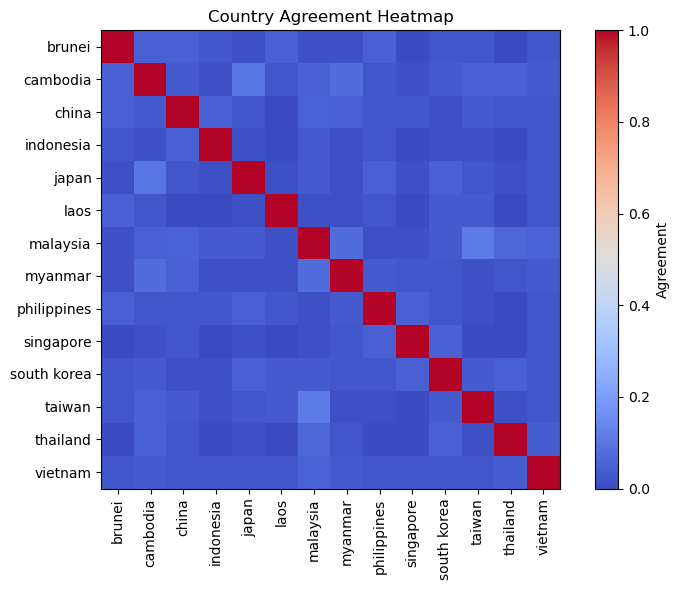

In [10]:
def run_simulation():
    # Load political leaders data
    with open("asian_pacific_leaders_quotes.json", "r", encoding="utf-8") as f:
        leaders_data = json.load(f)["asian_pacific_leaders_quotes"]

    # Flatten JSON into a player list with metadata
    leaders = {}
    
    for country, leader_dict in leaders_data.items():
        if not isinstance(leader_dict, dict):
            continue
    
        for leader_id, info in leader_dict.items():
            if not isinstance(info, dict):
                continue
            
            # Skip any summary/metadata entries
            if leader_id.startswith("extraction_summary"):
                continue
            
            # Only accept actual leaders
            if "quotes" in info or "position" in info or "years" in info:
                leaders[leader_id] = Leader(country, leader_id, info)



    game = FukushimaHashtagGame(
        leaders_json_path="asian_pacific_leaders_quotes.json",
        total_rounds=40
    )
    timestep = game.reset()
    
    while not timestep.terminal:
        player = game.get_next_player()
        if player:
            timestep = game.step(player, None)
    
    logger.info("Simulation complete!")
    return game

if __name__ == "__main__":
    game = run_simulation()  # modify run_simulation to return the game object

    all_rounds_data = []

    # Use the game object instead of self
    for round_idx, round_dict in enumerate(game.selected_hashtag_history):
        round_list = []
        for player, hashtag in round_dict.items():
            leader = game.player_to_leader[player]
            round_list.append({
                "country": leader.country,
                "player": player,
                "hashtag": hashtag
            })
        all_rounds_data.append(round_list)
    
    # Now compute the heatmap
    compute_country_agreement_heatmap(all_rounds_data)

